### Load base model (names set as *_nonlinear.pth)

In [1]:
from ptlpinns.models import model, training, load, transfer
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

name = "overdamped_nonlinear"
base_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}/"
base_name = f"model_{name}.pth"
base_model, training_log = model.load_model(base_path, base_name)

10 True False False [128, 128, 256]


### Initialize transfer learning model

In [2]:
transfer_model = model.transfer_model(training_log, base_model)

### Transfer learning parameters

In [3]:
w_transfer = [1]
zeta_transfer = [30]
q = 3
N = 512
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)
ic = [1, 0]
initial_condition_functions = [load.initial_condition(y1_0=ic[0], y2_0=ic[1])]
epsilon = 0.5
equation_functions = [equations.equation_oscillator(w_0=w_transfer[0], epsilon=epsilon, zeta=zeta_transfer[0])]
forcing_functions = [forcing.zeroes_2D(False)]

In [4]:
ode = equations.ode_oscillator_1D(w_0=w_transfer[0], zeta=zeta_transfer[0], forcing_1D = lambda t: np.zeros_like(t), q=q, epsilon=epsilon)
numerical_solution = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic)

### Transfer learning

In [5]:
optimizer = torch.optim.Adam(model.head_parameters(transfer_model), lr=1e-2)
num_iter = 50000
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.95)

In [6]:
transfer.compute_transfer_learning(transfer_model, optimizer, num_iter,
                        equation_functions, initial_condition_functions, forcing_functions,
                        N=N, t_span=t_span, numerical_solution=numerical_solution, every=250,
                        ode_weight=5, ic_weight=1.0)

[iteration] 250 | total 1.024e-01 | ode 1.614e-02 | ic 2.165e-02 | MAE 4.335e-01 | time 8.51
[iteration] 500 | total 4.472e-01 | ode 8.808e-02 | ic 6.815e-03 | MAE 4.024e-01 | time 19.31
[iteration] 750 | total 2.552e-02 | ode 4.378e-03 | ic 3.627e-03 | MAE 3.778e-01 | time 27.79
[iteration] 1000 | total 1.888e-02 | ode 3.372e-03 | ic 2.021e-03 | MAE 3.555e-01 | time 36.35
[iteration] 1250 | total 1.473e-02 | ode 2.688e-03 | ic 1.295e-03 | MAE 3.337e-01 | time 44.62
[iteration] 1500 | total 2.587e-02 | ode 4.994e-03 | ic 9.017e-04 | MAE 3.143e-01 | time 52.90
[iteration] 1750 | total 1.160e-02 | ode 2.165e-03 | ic 7.754e-04 | MAE 2.952e-01 | time 61.03
[iteration] 2000 | total 9.976e-03 | ode 1.860e-03 | ic 6.743e-04 | MAE 2.763e-01 | time 69.61
[iteration] 2250 | total 5.233e-02 | ode 1.032e-02 | ic 7.418e-04 | MAE 2.603e-01 | time 78.25
[iteration] 2500 | total 9.102e-03 | ode 1.706e-03 | ic 5.709e-04 | MAE 2.451e-01 | time 86.36
[iteration] 2750 | total 7.235e-03 | ode 1.344e-03 | i

### Plotting the results

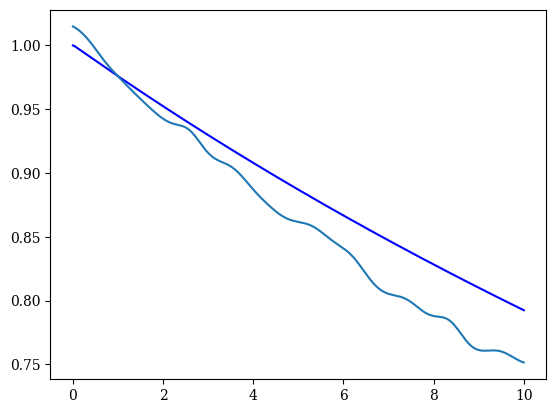

In [7]:
plt.plot(t_eval, numerical_solution[0, :], label='Numerical Solution', color='blue')
plt.plot(t_eval, transfer_model(training.generate_eval_tensor(N, t_span, False))[0].squeeze()[:, 0].detach().numpy())